In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt #v3.1.0
%matplotlib inline

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

## Setting some parameters

In [4]:
data_column = 'body' #training data
pred_column = 'category' #ticket_type, category, sub_category (for each category separately), etc
cv = 3 #number of folds for cross validation

## Reading data

In [5]:
data = pd.read_csv('all_tickets.csv')

In [6]:
data.head()

,title,body,ticket_type,category,sub_category1,sub_category2,business_service,urgency,impact
0,NaN,hi since recruiter lead permission approve req...,1,4,2,21,71,3,4
1,connection with icon,icon dear please setup icon per icon engineers...,1,6,22,7,26,3,4
2,work experience user,work experience user hi work experience studen...,1,5,13,7,32,3,4
3,requesting for meeting,requesting meeting hi please help follow equip...,1,5,13,7,32,3,4
4,reset passwords for external accounts,re expire days hi ask help update passwords co...,1,4,2,76,4,3,4


In [7]:
data.shape

(48549, 9)

## Number of rows for each class

In [8]:
rows_per_class = data.groupby(pred_column)[data_column].count() #count number of rows for each class
rows_per_class

category
0         4
1        72
2         3
3       137
4     34061
5      9634
6      2628
7       921
8       239
9       191
10        2
11      612
12       45
Name: body, dtype: int64

In [9]:
print('Number of unique classes:', len(np.unique(data[pred_column])))

Number of unique classes: 13


## Remove poorly represented classes (with less than n examples)

In [10]:
n = 50 #number of rows per class (if less - delete class)

In [11]:
tags = rows_per_class[rows_per_class > n].index #choose only those classes, that have more than n rows
tags

Int64Index([1, 3, 4, 5, 6, 7, 8, 9, 11], dtype='int64', name='category')

In [12]:
data = data[data[pred_column].isin(tags)] #choose rows, that belong to the classes, that have more than n rows
data.shape

(48495, 9)

In [13]:
print('Number of unique classes:', len(np.unique(data[pred_column]))) #numbre of classes after removing 

Number of unique classes: 9


## Get only useful data and split it

In [14]:
y = data[pred_column]

In [15]:
X = data[data_column]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7) #splitting with 70% : 30% ratio 

## Extracting features from text

In [17]:
count_vect = CountVectorizer(stop_words='english')

In [18]:
X_train = count_vect.fit_transform(X_train)
X_train.shape

(14548, 8704)

In [19]:
tfidf = TfidfTransformer()

In [20]:
X_train = tfidf.fit_transform(X_train)
X_train.shape

(14548, 8704)

### Extracting features from test set using model trained on the training set

In [21]:
X_test = count_vect.transform(X_test)

In [22]:
X_test = tfidf.transform(X_test)

In [23]:
X_test.shape

(33947, 8704)

## Function for drawing confusion matrix

In [24]:
def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1.3)
    sns.heatmap(conf_matrix, cmap='OrRd', square=True, annot=True, fmt='d', cbar=True,
                xticklabels=np.unique(y_test),
                yticklabels=np.unique(y_test))
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.show()

## Training model

### Naive Bayes

In [116]:
NB_params = {
    'alpha' : [0.001, 0.01, 0.1, 1, 10]
}

In [117]:
NB_clf = MultinomialNB()

In [118]:
NB_model = GridSearchCV(NB_clf, NB_params, cv=cv, iid=True, n_jobs=-1)

In [119]:
NB_model.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [120]:
NB_model.best_estimator_

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

In [121]:
predicted_NB = NB_model.predict(X_test)

In [122]:
accuracy_NB = np.mean(predicted_NB == y_test)
accuracy_NB

0.8342710696085074

In [32]:
conf_matrix_NB = confusion_matrix(y_test, predicted_NB)

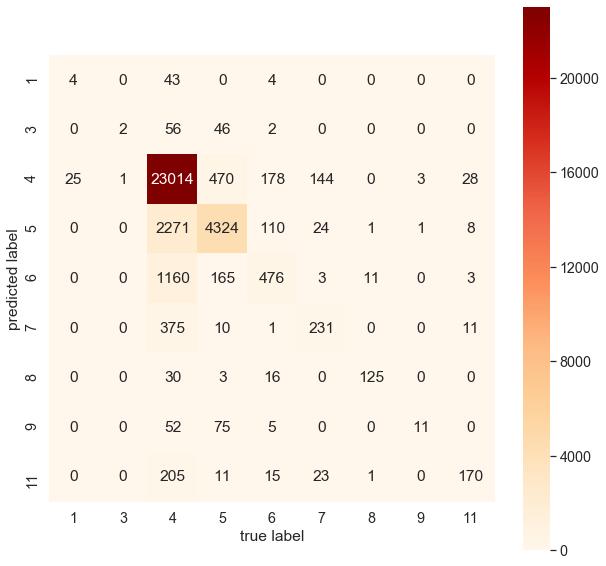

In [33]:
plot_confusion_matrix(conf_matrix_NB)

In [34]:
print(classification_report(y_test, predicted_NB, labels=np.unique(y_test)))

              precision    recall  f1-score   support

           1       0.14      0.08      0.10        51
           3       0.67      0.02      0.04       106
           4       0.85      0.96      0.90     23863
           5       0.85      0.64      0.73      6739
           6       0.59      0.26      0.36      1818
           7       0.54      0.37      0.44       628
           8       0.91      0.72      0.80       174
           9       0.73      0.08      0.14       143
          11       0.77      0.40      0.53       425

   micro avg       0.84      0.84      0.84     33947
   macro avg       0.67      0.39      0.45     33947
weighted avg       0.82      0.84      0.82     33947



### SVM

In [143]:
SVM_params = {
    'C' : [0.01, 0.1, 1, 10]
}

In [144]:
SVM_clf = SVC(kernel='linear')

In [145]:
SVM_model = GridSearchCV(SVM_clf, SVM_params, cv=cv, n_jobs=-1)

In [146]:
SVM_model.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1, param_grid={'C': [1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [147]:
SVM_model.best_estimator_

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [148]:
predicted_SVM = SVM_model.predict(X_test)

In [149]:
accuracy_SVM = np.mean(predicted_SVM == y_test)
accuracy_SVM

0.8404866409402892

In [64]:
conf_matrix_SVM = confusion_matrix(y_test, predicted_SVM)

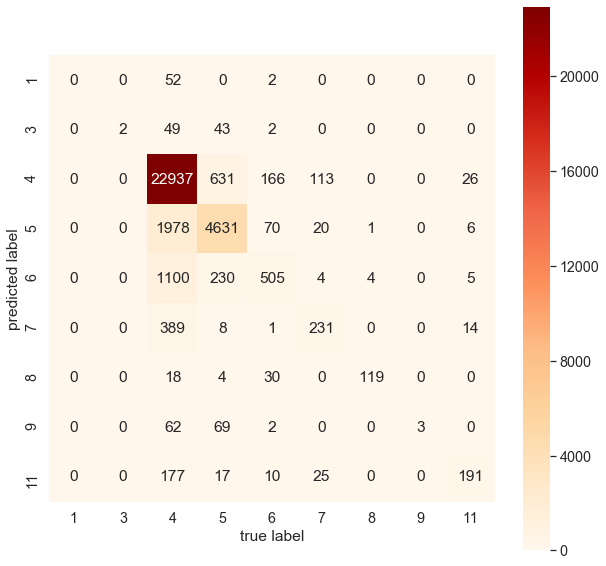

In [65]:
plot_confusion_matrix(conf_matrix_SVM)

In [66]:
print(classification_report(y_test, predicted_SVM, labels=np.unique(y_test)))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        54
           3       1.00      0.02      0.04        96
           4       0.86      0.96      0.91     23873
           5       0.82      0.69      0.75      6706
           6       0.64      0.27      0.38      1848
           7       0.59      0.36      0.45       643
           8       0.96      0.70      0.81       171
           9       1.00      0.02      0.04       136
          11       0.79      0.45      0.58       420

   micro avg       0.84      0.84      0.84     33947
   macro avg       0.74      0.39      0.44     33947
weighted avg       0.83      0.84      0.83     33947



### SVM with rbf kernel

In [67]:
SVM_rbf_params = [
    {'C' : [0.1, 1, 10]},
    {'gamma' : [0.001, 0.01, 0.1, 1]}
]

In [68]:
SVM_rbf_clf = SVC(kernel='rbf')

In [69]:
SVM_rbf_model = GridSearchCV(SVM_rbf_clf, SVM_rbf_params, cv=cv, n_jobs=-1)

In [70]:
SVM_rbf_model.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'C': [0.1, 1, 10]}, {'gamma': [0.001, 0.01, 0.1, 1]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [71]:
SVM_rbf_model.best_estimator_

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [72]:
predicted_SVM_rbf = SVM_rbf_model.predict(X_test)

In [73]:
accuracy_SVM_rbf = np.mean(predicted_SVM_rbf == y_test)
accuracy_SVM_rbf

0.8396912834712935

In [74]:
conf_matrix_SVM_rbf = confusion_matrix(y_test, predicted_SVM_rbf)

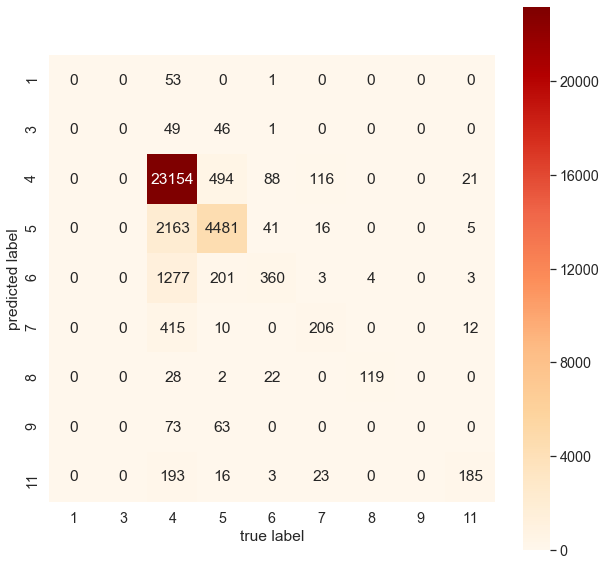

In [75]:
plot_confusion_matrix(conf_matrix_SVM_rbf)

In [76]:
print(classification_report(y_test, predicted_SVM_rbf, labels=np.unique(y_test)))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        54
           3       0.00      0.00      0.00        96
           4       0.84      0.97      0.90     23873
           5       0.84      0.67      0.75      6706
           6       0.70      0.19      0.30      1848
           7       0.57      0.32      0.41       643
           8       0.97      0.70      0.81       171
           9       0.00      0.00      0.00       136
          11       0.82      0.44      0.57       420

   micro avg       0.84      0.84      0.84     33947
   macro avg       0.53      0.37      0.42     33947
weighted avg       0.82      0.84      0.82     33947



### Random forest

In [122]:
RF_params = [
    {'n_estimators' : [1, 5, 10, 20]},
    {'max_depth' : [1, 2, 5, 10]},
]

In [116]:
RF_clf = RandomForestClassifier(n_jobs=-1)

In [117]:
RF_model = GridSearchCV(RF_clf, RF_params, cv=cv, n_jobs=-1)

In [118]:
RF_model.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'n_estimators': [20]}, {'max_depth': [2]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [119]:
RF_model.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [120]:
predicted_RF = RF_model.predict(X_test)

In [121]:
accuracy_RF = np.mean(predicted_RF == y_test)
accuracy_RF

0.8211918578961322

In [84]:
conf_matrix_RF = confusion_matrix(y_test, predicted_RF)

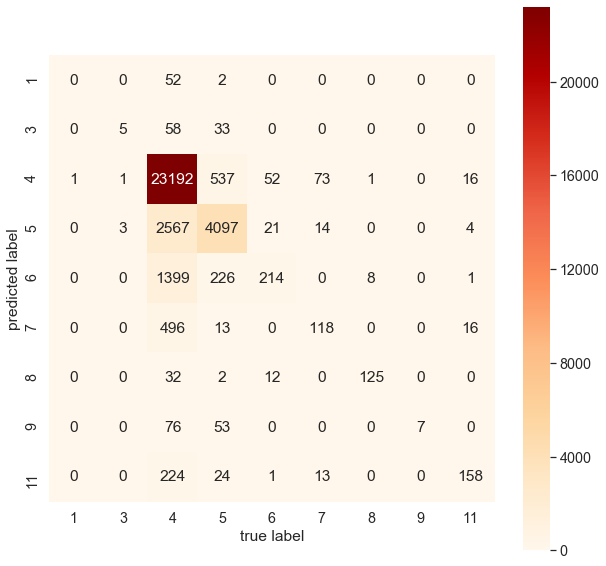

In [85]:
plot_confusion_matrix(conf_matrix_RF)

In [86]:
print(classification_report(y_test, predicted_RF, labels=np.unique(y_test)))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        54
           3       0.56      0.05      0.10        96
           4       0.83      0.97      0.89     23873
           5       0.82      0.61      0.70      6706
           6       0.71      0.12      0.20      1848
           7       0.54      0.18      0.27       643
           8       0.93      0.73      0.82       171
           9       1.00      0.05      0.10       136
          11       0.81      0.38      0.51       420

   micro avg       0.82      0.82      0.82     33947
   macro avg       0.69      0.34      0.40     33947
weighted avg       0.81      0.82      0.79     33947



### KNN

In [87]:
KNN_params = {
    'n_neighbors' : [1, 2, 5, 10]
}

In [88]:
KNN_clf = KNeighborsClassifier(n_jobs=-1)

In [89]:
KNN_model = GridSearchCV(KNN_clf, KNN_params, cv=cv, n_jobs=-1)

In [90]:
KNN_model.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_neighbors': [1, 2, 5, 10]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [91]:
KNN_model.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=10, p=2,
           weights='uniform')

In [92]:
predicted_KNN = KNN_model.predict(X_test)

In [93]:
accuracy_KNN = np.mean(predicted_KNN == y_test)
accuracy_KNN

0.8231360650425663

In [94]:
conf_matrix_KNN = confusion_matrix(y_test, predicted_KNN)

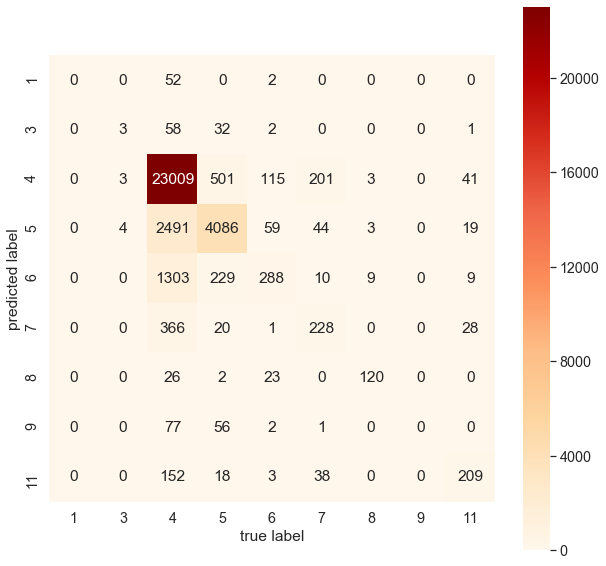

In [95]:
plot_confusion_matrix(conf_matrix_KNN)

In [96]:
print(classification_report(y_test, predicted_KNN, labels=np.unique(y_test)))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        54
           3       0.30      0.03      0.06        96
           4       0.84      0.96      0.90     23873
           5       0.83      0.61      0.70      6706
           6       0.58      0.16      0.25      1848
           7       0.44      0.35      0.39       643
           8       0.89      0.70      0.78       171
           9       0.00      0.00      0.00       136
          11       0.68      0.50      0.57       420

   micro avg       0.82      0.82      0.82     33947
   macro avg       0.51      0.37      0.41     33947
weighted avg       0.80      0.82      0.80     33947



## Predicting sub_category

In [25]:
def sub_category(data):
    pred_column = 'sub_category1'
    
    rows_per_class = data.groupby(pred_column)[data_column].count() 
    tags = rows_per_class[rows_per_class > 3].index
    data = data[data[pred_column].isin(tags)]
    if len(data) == 0 or len(np.unique(data[pred_column])) < 2:
        return None

    y = data[pred_column]
    X = data[data_column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 
    
    count_vect_sub = CountVectorizer(stop_words='english')
    X_train = count_vect_sub.fit_transform(X_train)
    X_test = count_vect_sub.transform(X_test)
    
    tfidf_sub = TfidfTransformer()
    X_train = tfidf_sub.fit_transform(X_train)
    X_test = tfidf_sub.transform(X_test)
    
    clf_NB = MultinomialNB(alpha=0.01)
    clf_SVM = SVC(C=1, kernel='linear')
    clf_SVM_rbf = SVC(C=1, gamma=1, kernel='rbf')
    clf_RF = RandomForestClassifier(n_estimators=20, max_depth=5)
    clf_KNN =  KNeighborsClassifier(n_neighbors=5)

    f1s = []
    for model in [clf_NB, clf_SVM, clf_SVM_rbf, clf_RF, clf_KNN]:
        model.fit(X_train, y_train)
        predicted = model.predict(X_test)
        f1s.append(f1_score(y_test, predicted, average='micro'))
    return f1s

In [26]:
for i in np.unique(data['category']):
    data_cat = data.loc[data['category'] == i]
    if len(np.unique(data_cat['sub_category1'])) < 2:
        print('Category {}: not enough data to train models\n'.format(i))
        continue
        
    algos = ['NB', 'SVM', 'SVM(rbf)', 'RF', 'KNN']    
    f1s = sub_category(data_cat)
    if f1s != None:
        print('Category {}, number of examples {}:'.format(i, len(data_cat)))
        for algo, f1 in zip(algos, f1s):
            print('F1 score for {} algorithm = {}'.format(algo, f1))
        print()
    else:
        print('Category {}: not enough data to train models\n'.format(i))

Category 1, number of examples 72:
F1 score for NB algorithm = 0.6923076923076923
F1 score for SVM algorithm = 0.6923076923076923
F1 score for SVM(rbf) algorithm = 0.6923076923076923
F1 score for RF algorithm = 0.46153846153846156
F1 score for KNN algorithm = 0.5384615384615384

Category 3, number of examples 137:
F1 score for NB algorithm = 0.8148148148148148
F1 score for SVM algorithm = 0.8518518518518519
F1 score for SVM(rbf) algorithm = 0.7777777777777778
F1 score for RF algorithm = 0.6666666666666666
F1 score for KNN algorithm = 0.18518518518518517

Category 4, number of examples 34061:
F1 score for NB algorithm = 0.5737560546014971
F1 score for SVM algorithm = 0.5953324526640247
F1 score for SVM(rbf) algorithm = 0.6060472625862322
F1 score for RF algorithm = 0.38573315719947165
F1 score for KNN algorithm = 0.4583883751651255

Category 5, number of examples 9634:
F1 score for NB algorithm = 0.7846393357550596
F1 score for SVM algorithm = 0.8074727555786196
F1 score for SVM(rbf) al

## Finding category for given text

In [38]:
text_to_classify = input('Enter text of your ticket: ')

Enter text of your ticket: badge removed dear please badge since he working anymore best regards


In [39]:
text = pd.DataFrame([text_to_classify.lower()])

In [40]:
text = count_vect.transform(text[0])
text = tfidf.transform(text)
text.shape

(1, 8704)

In [32]:
svm_clf = SVC(kernel='linear')
svm_clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [41]:
predicted_category = svm_clf.predict(text)
print(predicted_category)

[4]
